# Quadcopter 6DOF Simulation



In [5]:
import numpy as np
import scipy.linalg as splin


# Physical Constants
m = 0.1         #kg
Ixx = 0.00062   #kg-m^2
Iyy = 0.00113   #kg-m^2
Izz = 0.9*(Ixx + Iyy) #kg-m^2 (Assume nearly flat object, z=0)
dx = 0.114      #m
dy = 0.0825     #m
g = 9.81  #m/s/s
DTR = 1/57.3; RTD = 57.3


# Simulation time and model parameters
tstep = .01            # Sampling time (sec)
simulation_time = 10   # Length of time to run simulation (sec)
t = np.arange(0,simulation_time,tstep)   # time array

# Model size
n_states = 12  # Number of states
n_inputs = 4   # Number of inputs


# Initialize State Conditions
x = np.zeros((n_states,np.size(t)))  # time history of state vectors
# Initial height
x[11,0] = 0.3
# Initial pitch angle theta
x[7,0] = 0.2


# Initialize inputs
u = np.zeros((n_inputs,np.size(t)))  # time history of input vectors
# Initial control inputs
u[:,0] = np.zeros(4)

## Aerodynamics Model

In [6]:
# Propeller Thrust function
def Fthrust(u):
    #Input: u (PWM)
    #Return: Thrust (Newtons)
    return 0.00128*u - 1.55
    
# Torque function
def T(F,dx,dy):
    # Returns torque about cg given thrust force and dx,dy distance from cg
    return 0


## Equations of Motion

In [9]:
# Nonlinear Dynamics Equations of Motion
def f(x,u):
    # Inputs: state vector (x), input vector (u)
    # Returns: time derivative of state vector (xdot)
    
    #  State Vector Reference:
    #idx  0, 1, 2, 3, 4, 5,  6,   7,   8,   9, 10, 11
    #x = [u, v, w, p, q, r, phi, the, psi, xE, yE, hE]
    
    # Store state variables in a readable format
    ub = x[0]
    vb = x[1]
    wb = x[2]
    p = x[3]
    q = x[4]
    r = x[5]
    phi = x[6]
    theta = x[7]
    psi = x[8]
    xE = x[9]
    yE = x[10]
    hE = x[11]
    
    # Calculate forces from propeller inputs (u)
    F1 = Fthrust(u[0])
    F2 = Fthrust(u[1])
    F3 = Fthrust(u[2])
    F4 = Fthrust(u[3])
    Fz = F1 + F2 + F3 + F4
    L = (F1 + F4) * dy - (F2 + F3) * dy
    M = (F1 + F3) * dx - (F2 + F4) * dx
    N = -T(F1,dx,dy) - T(F2,dx,dy) + T(F3,dx,dy) + T(F4,dx,dy)
    
    # Pre-calculate trig values
    cphi = np.cos(phi);   sphi = np.sin(phi)
    cthe = np.cos(theta); sthe = np.sin(theta)
    cpsi = np.cos(psi);   spsi = np.sin(psi)
    
    # Calculate the derivative of the state matrix using EOM
    xdot = np.zeros(12)
    
    xdot[0] = -g * sthe + r * vb - q * wb  # = udot
    xdot[1] = g * sphi*cthe - r * ub + p * wb # = vdot
    xdot[2] = 1/m * (-Fz) + g*cphi*cthe + q * ub - p * vb # = wdot
    xdot[3] = 1/Ixx * (L + (Iyy - Izz) * q * r)  # = pdot
    xdot[4] = 1/Iyy * (M + (Izz - Ixx) * p * r)  # = qdot
    xdot[5] = 1/Izz * (N + (Ixx - Iyy) * p * q)  # = rdot
    xdot[6] = p + (q*sphi + r*cphi) * sthe / cthe  # = phidot
    xdot[7] = q * cphi - r * sphi  # = thetadot
    xdot[8] = (q * sphi + r * cphi) / cthe  # = psidot
    
    xdot[9] = cthe*cpsi*xdot[0] + (-cthe*spsi + sphi*sthe*cpsi) * x[1] + \
        (sphi*spsi+cphi*sthe*cpsi) * xdot[2]  # = xEdot
        
    xdot[10] = cthe*spsi * xdot[0] + (cphi*cpsi+sphi*sthe*spsi) * xdot[1] + \
        (-sphi*cpsi+cphi*sthe*spsi) * xdot[2] # = yEdot
        
    xdot[11] = -1*(-sthe * xdot[0] + sphi*cthe * xdot[1] + \
        cphi*cthe * xdot[2]) # = hEdot
    
    return xdot




## Numerical Integrator

In [11]:
# 4th Order Runge Kutta Calculation
def RK4(x,u,dt):
    # Inputs: x[k], u[k], dt (time step, seconds)
    # Returns: x[k+1]
    
    # Calculate slope estimates
    K1 = f(x,u)
    K2 = f(x + K1 * dt / 2, u)
    K3 = f(x + K2 * dt / 2, u)
    K4 = f(x + K3 * dt, u)
    
    # Calculate x[k+1] estimate using combination of slope estimates
    x_next = x + 1/6 * (K1 + 2*K2 + 2*K3 + K4) * dt
    
    return x_next



# March through time array and numerically solve for vehicle states

for k in range(1,np.size(t)):   #run for 60 sec
    
    # State truth
    x[:,k] = RK4(x[:,k-1], u[:,k-1], tstep)
    
    #Ground detection
    #if x[11,k] < 0:
    #    x[11,k] = 0
    #    x[2,k] = max(0,x[1,k])
        
    # Sensed information - assumes perfect knowledge
    phi = x[6,k]
    theta = x[7,k]
    p = x[3,k]
    q = x[4,k]
    r = x[5,k]
    
    h = x[11,k]
    hdot = -x[2,k]  #for small angle
    
    
    # Calculate euler angle rates from sensed information
    sphi = np.sin(phi)
    cphi = np.cos(phi)
    tan_theta = np.tan(theta)
    phidot = p + (q * sphi + r * cphi) * tan_theta
    thetadot = q * cphi - r * sphi
    
        
    # Control Law Gains
    Kp = 500
    Kd = 50
    Kh = 500
    Khdot = 250
    
    #State error
    #e = x[:,k] - xc[:,k]
    
    # Reference values
    hCmd = 0.2

    #feedback = K * [e,None]    # e must be a column vector
    #u[:,k] = np.array([T1e,T2e]).T - feedback.A1
    #u[:,k] = u[:,k-1]
    
    pitch = -Kp*theta - Kd*thetadot
    roll = -Kp*phi - Kd*phidot
    height = -Kh*(h - hCmd) - Khdot*hdot
    
    trim = 1402
    
    u[0,k] = int(roll + pitch + height) + trim
    u[1,k] = int(-roll - pitch + height) + trim
    u[2,k] = int(-roll + pitch + height) + trim
    u[3,k] = int(roll - pitch + height) + trim
    
    
    # Limits
    u[0,k] = max(1000,min(2000,u[0,k]))
    u[1,k] = max(1000,min(2000,u[1,k]))
    u[2,k] = max(1000,min(2000,u[2,k]))
    u[3,k] = max(1000,min(2000,u[3,k]))


## Plot Results

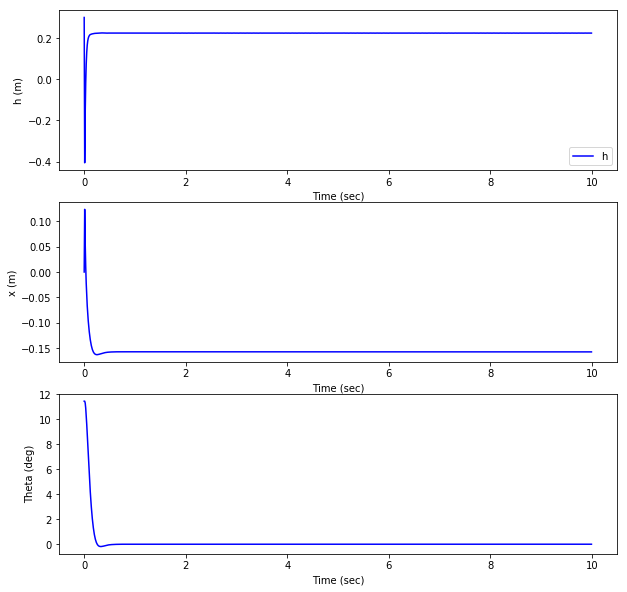

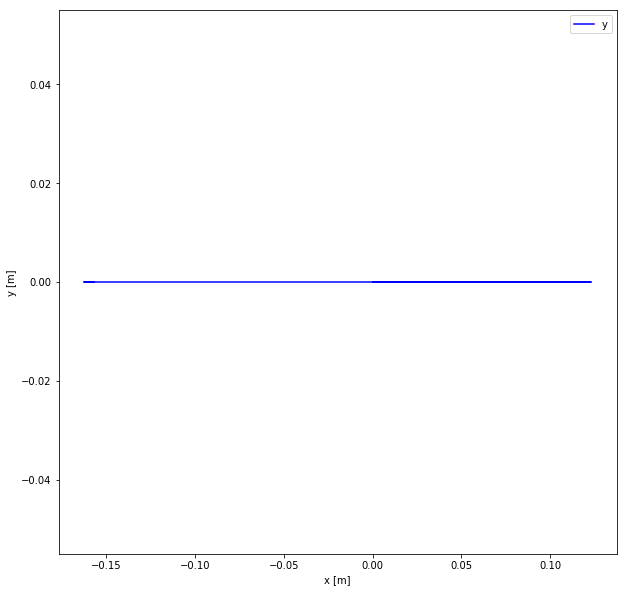

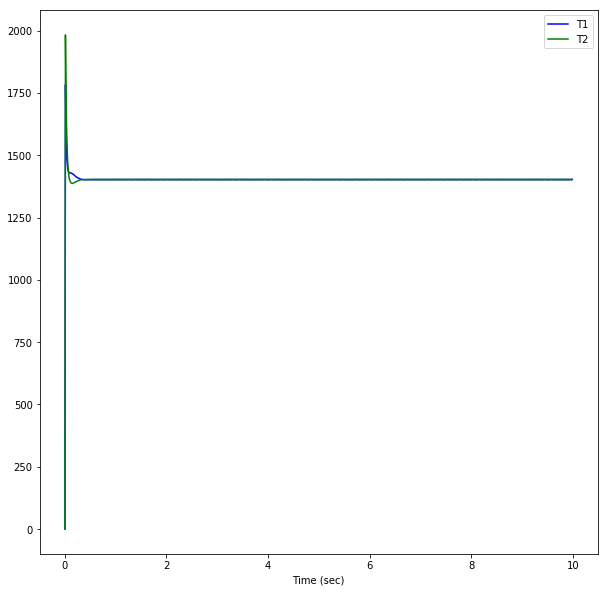

In [16]:
from pylab import *
# Visualizations will be shown in the notebook.
%matplotlib inline


figure(1, figsize=(10,10))
subplot(311)
plot(t,x[11,:],'b',label='h')
ylabel('h (m)')
xlabel('Time (sec)')
legend(loc='best')

subplot(312)
plot(t,x[9,:],'b',label='x')
ylabel('x (m)')
xlabel('Time (sec)')
#plot(t,x[2,:]*57.3,'b',label='x')
#ylabel('pitch rate [deg/s]')

subplot(313)
plot(t,x[7,:]*57.3,'b',label='theta')
ylabel('Theta (deg)')
xlabel('Time (sec)')

figure(2, figsize=(10,10))
plot(x[9,:],x[10,:],'b',label='y')
ylabel('y [m]'); xlabel('x [m]')
legend(loc='best')

figure(3, figsize=(10,10))
plot(t,u[0,:],'b',label='T1')
plot(t,u[1,:],'g',label='T2')
xlabel('Time (sec)')
legend(loc='best')

#figure(4)
#plot(t,height)

show()